In [1]:
pip install scikit-learn

In [2]:
# Library imports.
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB # ?
from sklearn.naive_bayes import MultinomialNB # ?
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer

import re

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

from sklearn import metrics # ??

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from keras.models import Model
# from keras import layers
from keras import Input

from tensorflow.keras.utils import plot_model

In [3]:
# Dataset from Kaggle.
# https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health?resource=download

In [4]:
# For reading a "local" CSV using Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset = pd.read_csv("/content/drive/MyDrive/Final Project/dataset/Combined_Data.csv") # keep an eye on whitespace?
dataset.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
dataset.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [7]:
# Make a safe copy of the CSV data for cleaning and processing later.
dataset_clean = dataset.copy()
dataset_clean.dropna(inplace = True)

In [8]:
dataset_clean.describe()

,Unnamed: 0
count,52681.000000
mean,26365.706042
std,15235.065306
min,0.000000
25%,13180.000000
50%,26350.000000
75%,39522.000000
max,53042.000000


In [9]:
# preparing to add stemming
nltk.download('punkt')
nltk.download('punkt_tab')

# Using Porter stemmer algorithm, fairly straightforward, geared to English (not Lancaster or Snowball)
stemmer = PorterStemmer()

# keep an eye on the performance cost on this one, since we're tokenizing then going back to a string (and tokenizing is done again later, monitor necessity of this)
# should work for both the Naive Bayes and the RNN (and the DummyClassifier for the common sense baseline)
def stemming(statement_text):
  # Tokenize each word in the statement for now, preparing for stemming
  word_tokens = nltk.word_tokenize(statement_text)
  # Perform stemming on each word now that they're separated
  post_stemming = [stemmer.stem(word) for word in word_tokens]
  # Going back to a string for further working
  return " ".join(post_stemming)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
def clean_statements(statement_text): # clean this up later
    # Remove punctuation, special characters, any remaining non-letter characters (?) and extra whitespace
    statement_text = re.sub(r'[^a-zA-Z\s]', '', statement_text)
    statement_text = re.sub(r'\s+', ' ', statement_text) # remove extra whitespace

    # Convert everything to lowercase and remove extra whitespace (?) (redundant with regex above? check)
    statement_text = statement_text.lower().strip() # need?
    return statement_text



In [11]:
noisy_text = dataset_clean["statement"][352]

clean_text_result = clean_statements(noisy_text)

print("Before and after comparison of a cleaned statement:")
print(dataset_clean["statement"][352])
print(clean_text_result)

Before and after comparison of a cleaned statement:
Usually every night when you're alone you're restless, it's calm. It feels so different.
usually every night when youre alone youre restless its calm it feels so different


In [12]:
# Take our cleaning function and apply it to all of the social media statements.
# Then temporarily make a new column for the cleaned statement for easier viewing.
dataset_clean['processed_statement'] = dataset_clean['statement'].apply(clean_statements)
dataset_clean.head()

,Unnamed: 0,statement,status,processed_statement
0,0,oh my gosh,Anxiety,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...


In [13]:
# Apply our stemming function to our cleaned statements.
dataset_clean['processed_statement'] = dataset_clean['processed_statement'].apply(stemming)
dataset_clean.head()

,Unnamed: 0,statement,status,processed_statement
0,0,oh my gosh,Anxiety,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,troubl sleep confus mind restless heart all ou...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shift my focu to someth els but im still w...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless it been a month now b...


In [14]:
print("Before and after comparison of a cleaned statement after stemming:")
print(dataset_clean["statement"][352])
print(dataset_clean["processed_statement"][352])

Before and after comparison of a cleaned statement after stemming:
Usually every night when you're alone you're restless, it's calm. It feels so different.
usual everi night when your alon your restless it calm it feel so differ


In [15]:
# Let's see all the unique statuses.
dataset_clean["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

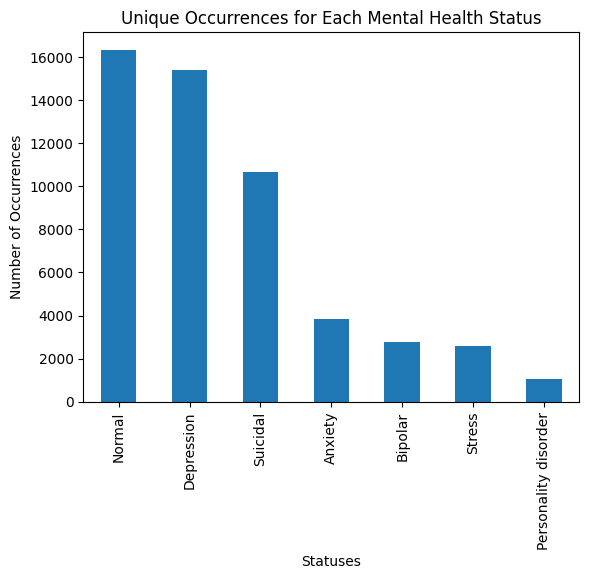

In [16]:
# Let's create a bar chart showing the number of unique occurrences of each status, now that we have cleaned out null and/or empty entries.
# Collect the number of unique occurrences.
status_counts = dataset_clean['status'].value_counts()

# Create the bar chart
status_counts.plot(kind='bar')
plt.xlabel('Statuses')
plt.ylabel('Number of Occurrences')
plt.title('Unique Occurrences for Each Mental Health Status')
plt.show()

In [17]:
# Let's encode all of the statuses so that our models can work with them for classification.
# from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()

# Temporarily just make a new column for the encoded mental health status for easier viewing.
dataset_clean["encoded_status"] = label_encode.fit_transform(dataset_clean["status"])
dataset_clean.head()

,Unnamed: 0,statement,status,processed_statement,encoded_status
0,0,oh my gosh,Anxiety,oh my gosh,0
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,troubl sleep confus mind restless heart all ou...,0
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,0
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shift my focu to someth els but im still w...,0
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless it been a month now b...,0


In [18]:
# Encoded classes?
statuses = label_encode.classes_ # the string names
statuses

array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

In [19]:
# Get unique status values
unique_status = dataset_clean['status'].unique()
unique_status

# Showing which integer values in encoded_status correspond with the string value in status
matching_values = dataset_clean[dataset_clean['status'].isin(unique_status)][['status', 'encoded_status']].drop_duplicates()

# Print the matching values
print(matching_values)

                     status  encoded_status
0                   Anxiety               0
733                  Normal               3
6982             Depression               2
6985               Suicidal               6
27346                Stress               5
45394               Bipolar               1
50654  Personality disorder               4


In [20]:
# dataset_clean.head() # can I randomize the rows that come out to view different statuses more easily?
print(dataset_clean["statement"][22327])
print(dataset_clean["processed_statement"][22327]) # create a rule so that "standarts...Living" becomes "standarts living" instead of "standartsliving"? for row 22327
print(dataset_clean["status"][22327])
print(dataset_clean["encoded_status"][22327])

there were rules to which obeyed, standarts...Living in a charade thy was all. No real purpose can save you when you are mentally ill. I have OCD non responsive to meds. Everday I lose a part of my identity. Constant fight beetween two spheres of my brain. I was a star dust and I am ready and fulfilled in life to go back to where everthing started. I love my friend Yamur which is a mix of passion and love and charity. I can do anything for her if I had been healthy enough.I love my family too they matter a lot. But I can not tolerate my daily melancholic suicidal depression and obsessions just for the sake of them. The world has no rules on grand scale no justice no purpose. we have to distract our mind and create and illusion each second just to forget we exist. Yes we exist and this must be a bad joke. We are walking to the eventual death of us each day. Some of us only suffer while some of us can be happy in their distraction.For example the girl I loved we are texting only Ilove he

In [21]:
# Split and train the data.
X = dataset_clean['processed_statement'] # feature
y = dataset_clean['encoded_status'] # target

print("X:", len(X), " y:", len(y)) # 52681 52681, both

X: 52681  y: 52681


In [22]:
# Split and train the data, split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # change random_state? no?

# Checking shape of training and test sets really quick
print("X train:", len(X_train), "y train:",  len(y_train))
print("X test:", len(X_test), "y test:", len(y_test))

X train: 42144 y train: 42144
X test: 10537 y test: 10537


In [23]:
# Vectorization
vectorizer = CountVectorizer(stop_words = "english") # play with parameters later(?)

# Use CountVectorizer to transform our training data for features
X_vectorized_train = vectorizer.fit_transform(X_train)

# Use CountVectorizer to transform our testing data for features
X_vectorized_test = vectorizer.transform(X_test)

In [24]:
# print(vectorizer.vocabulary_)

In [25]:
# Use the data we just prepared to fit and train a Dummy Classifier in order to obtain a common sense baseline, to be used to measure the models' performance.
dummy_baseline = DummyClassifier(strategy='stratified', random_state = 42) # random_state = 42 ? same as when using train_test_split on my models

dummy_baseline.fit(X_vectorized_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [26]:
# Getting our common sense baseline from the Dummy Classifier
y_pred_baseline = dummy_baseline.predict(X_vectorized_test)
acc_baseline = accuracy_score(y_test, y_pred_baseline) # accuracy
f1_baseline = f1_score(y_test, y_pred_baseline, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
prec_baseline = precision_score(y_test, y_pred_baseline, average="weighted") # precision
recall_baseline = recall_score(y_test, y_pred_baseline, average="weighted") # recall

print("Dummy Classifier Baseline:\n")
print("Accuracy:", acc_baseline)
print("F1 Score:", f1_baseline)
print("Precision:", prec_baseline)
print("Recall:", recall_baseline)

Dummy Classifier Baseline:

Accuracy: 0.2346018790927209
F1 Score: 0.23484934694182893
Precision: 0.23513114743747132
Recall: 0.2346018790927209


In [27]:
# Hyperparameter tuning with GridSearchCV here
# alpha smoothing
# note the force-alpha parameter of MultinomialNB, which by default forces alpha to be 1e-10 if it is ever set to be less than that, so no point in going past that
nb_param_grid = {
  'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
}

grid_scoring = 'accuracy'

nb_grid_cv = GridSearchCV(estimator = MultinomialNB(), param_grid = nb_param_grid, scoring = grid_scoring, verbose = 1, cv = 5) # n_jobs?
nb_grid_cv.fit(X_vectorized_train, y_train)
print(nb_grid_cv.best_estimator_)
print(nb_grid_cv.best_score_)
print(nb_grid_cv.best_params_) # 0.1 = 1e-1

Fitting 5 folds for each of 11 candidates, totalling 55 fits
MultinomialNB(alpha=0.1)
0.680001810820701
{'alpha': 0.1}


In [28]:
# Naive Bayes
# Build the Naive Bayes classifier.
nb_model = MultinomialNB(alpha = 0.1)

# Fit the model using the training set we prepared.
nb_model.fit(X_vectorized_train, y_train)

MultinomialNB(alpha=0.1)

In [29]:
# Evaluation of Multinomial Naive Bayes classifier (outside of k-fold validation).

y_pred = nb_model.predict(X_vectorized_test)
acc_nb = accuracy_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
prec_nb = precision_score(y_test, y_pred, average="weighted") # precision
recall_nb = recall_score(y_test, y_pred, average="weighted") # recall

print("Naive Bayes Classifier:\n")
print("Accuracy:", acc_nb)
print("F1 Score:", f1_nb)
print("Precision:", prec_nb)
print("Recall:", recall_nb)

Naive Bayes Classifier:

Accuracy: 0.6843503843598747
F1 Score: 0.6887144531276107
Precision: 0.7056141261479346
Recall: 0.6843503843598747


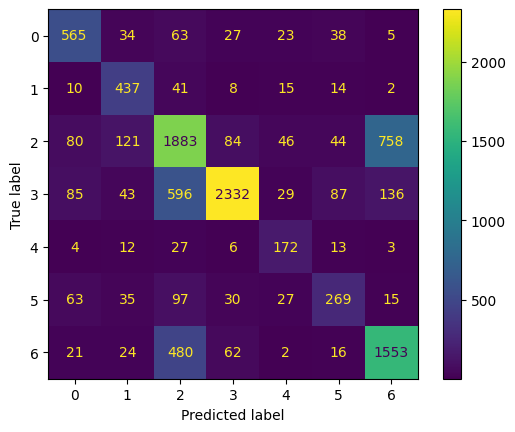

In [30]:
# Naive Bayes confusion matrix
matrix_labels = matching_values["encoded_status"] # need to fix!

nb_matrix = confusion_matrix(y_test, y_pred)

nb_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = nb_matrix)

nb_matrix_plot.plot()
plt.show()

In [31]:
all_nb_acc = []
all_nb_f1 = []
all_nb_prec = []
all_nb_recall = []

k = 5
nb_skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

for (train_index, test_index) in nb_skf.split(X_vectorized_train, y_train):
  X_train_fold, X_test_fold = X_vectorized_train[train_index], X_vectorized_train[test_index]
  y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

  # Get a fresh model
  nb_model_fold = MultinomialNB(alpha = 0.1)

  # Train the model
  nb_model_fold.fit(X_train_fold, y_train_fold)

  # Predict on test set
  y_pred = nb_model_fold.predict(X_test_fold)

  # Evaluate accuracy
  acc = accuracy_score(y_test_fold, y_pred)
  #
  f1_fold = f1_score(y_test_fold, y_pred, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
  prec_fold = precision_score(y_test_fold, y_pred, average="weighted") # precision
  recall_fold = recall_score(y_test_fold, y_pred, average="weighted") # recall
  #
  all_nb_acc.append(acc)
  all_nb_f1.append(f1_fold)
  all_nb_prec.append(prec_fold)
  all_nb_recall.append(recall_fold)

# Calculate and display averages
avg_acc_nb = np.mean(all_nb_acc)
avg_f1_nb = np.mean(all_nb_f1)
avg_prec_nb = np.mean(all_nb_prec)
avg_recall_nb = np.mean(all_nb_recall)
print("Average Accuracy of Naive Bayes Classifier: " + str(avg_acc_nb))
print("Average F1 Score of Naive Bayes Classifier: " + str(avg_f1_nb))
print("Average Precision of Naive Bayes Classifier: " + str(avg_prec_nb))
print("Average Recall of Naive Bayes Classifier: " + str(avg_recall_nb))

Average Accuracy of Naive Bayes Classifier: 0.6792664661513073
Average F1 Score of Naive Bayes Classifier: 0.6833733980727343
Average Precision of Naive Bayes Classifier: 0.6964204115159922
Average Recall of Naive Bayes Classifier: 0.6792664661513073


In [32]:
# Tokenize the text
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(dataset_clean['processed_statement'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("what is vocab_size?:", vocab_size)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(dataset_clean['processed_statement'])

# Pad sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post', truncating = 'post')

# Split data into training and testing sets
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_sequences, dataset_clean['encoded_status'], test_size = 0.2, random_state = 42)

# One-hot encode the target variable
y_train_rnn = tf.keras.utils.to_categorical(y_train_rnn, num_classes = 7) # I have 7 possible values for my target, so that's why this is 7
y_test_rnn = tf.keras.utils.to_categorical(y_test_rnn, num_classes = 7)

what is vocab_size?: 58873


In [33]:
# Recurrent Neural Network (RNN)

max_features = 10000
maxlen = 500

# keep
def build_rnn_func_submodels():
  inputs = Input(shape=(max_length,))  # used as argument for Model object

  # first argument is (max word index + 1), second argument is dimensionality of the embeddings
  embedding_layer = layers.Embedding(vocab_size, 256)(inputs) # word embedding
  dense_one = layers.Dense(128, kernel_regularizer=regularizers.L2(0.001), activation='relu')(embedding_layer)
  dropout_dense = layers.Dropout(0.15)(dense_one)

  ### first submodel
  submodel_one = Model(inputs = inputs, outputs = dropout_dense)

  ### second submodel
  inputs_two = Input(shape=(max_length, 128))
  bidirectional_layer = layers.Bidirectional(layers.LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))(inputs_two) # grabbed this from the first submodel
  # using 7 as the first argument because my target can have seven possible values
  outputs_two = layers.Dense(7, kernel_regularizer=regularizers.L2(0.001), activation='softmax')(bidirectional_layer)
  dropout_dense_two = layers.Dropout(0.1)(outputs_two)
  submodel_two = Model(inputs = inputs_two, outputs = outputs_two)

  # using both submodels
  combine_inputs = Input(shape=(max_length,))
  features = submodel_one(combine_inputs)
  final_output = submodel_two(features)

  model = Model(inputs = combine_inputs, outputs = final_output)  # Model object, uses inputs and outputs from before
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Display some additional info about the model on execution. Also helpful for keeping track of progress during stratified K-fold validation later.
  print(model.summary())
  return model


In [34]:
rnn_model_func_api = build_rnn_func_submodels()

# Fit and train the model.
rnn_func_history = rnn_model_func_api.fit(X_train_rnn, y_train_rnn, epochs = 5, batch_size = 512, validation_split = 0.2)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 100, 128)            │      15,104,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,369,351 (58.63 MB)

 Trainable params: 15,369,351 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 719ms/step - accuracy: 0.4958 - loss: 1.5723 - val_accuracy: 0.5682 - val_loss: 1.1865
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 704ms/step - accuracy: 0.5908 - loss: 1.0909 - val_accuracy: 0.6405 - val_loss: 0.9191
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 675ms/step - accuracy: 0.6590 - loss: 0.8662 - val_accuracy: 0.6972 - val_loss: 0.8180
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 692ms/step - accuracy: 0.7271 - loss: 0.7127 - val_accuracy: 0.7163 - val_loss: 0.7803
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 685ms/step - accuracy: 0.7621 - loss: 0.6432 - val_accuracy: 0.7325 - val_loss: 0.7461


In [35]:
# Final evaluation on testing set derived from split.
test_eval = rnn_model_func_api.evaluate(X_test_rnn, y_test_rnn)
print("One-time accuracy evaluation before gathering averages for the RNN:\n")
print(test_eval)

330/330 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.7412 - loss: 0.7162
One-time accuracy evaluation before gathering averages for the RNN:

[0.7203770875930786, 0.7366423010826111]


In [36]:
# predict probabilities for test set
y_pred_rnn = rnn_model_func_api.predict(X_test_rnn, verbose = 0)
# predict classes for test set
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis = 1)

# Convert y_test_rnn to a multiclass format like y_pred_rnn_classes
# to prevent a "multilabel-indicator and multiclass targets" error
y_test_rnn_classes = np.argmax(y_test_rnn, axis=1) # Convert to the same format as y_pred_rnn_classes

acc_rnn = accuracy_score(y_test_rnn_classes, y_pred_rnn_classes)
f1_rnn = f1_score(y_test_rnn_classes, y_pred_rnn_classes, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
prec_rnn = precision_score(y_test_rnn_classes, y_pred_rnn_classes, average="weighted") # precision
recall_rnn = recall_score(y_test_rnn_classes, y_pred_rnn_classes, average="weighted") # recall

print("Recurrent Neural Network:\n")
print("Accuracy:", acc_rnn)
print("F1 Score:", f1_rnn)
print("Precision:", prec_rnn)
print("Recall:", recall_rnn)

Recurrent Neural Network:

Accuracy: 0.7366423080573218
F1 Score: 0.7299467566865007
Precision: 0.746330805360307
Recall: 0.7366423080573218


<Figure size 640x480 with 0 Axes>

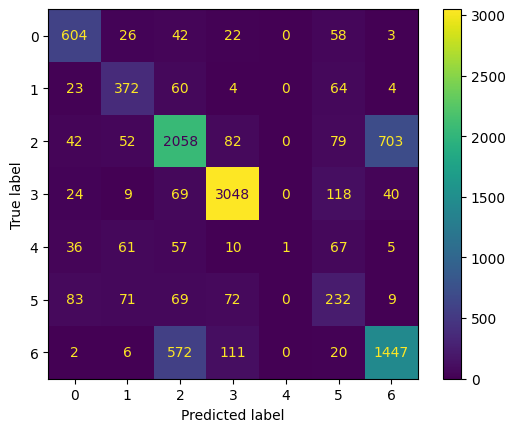

In [37]:
plt.clf()
rnn_matrix = confusion_matrix(y_test_rnn_classes, y_pred_rnn_classes)

rnn_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = rnn_matrix)

rnn_matrix_plot.plot()

plt.show()

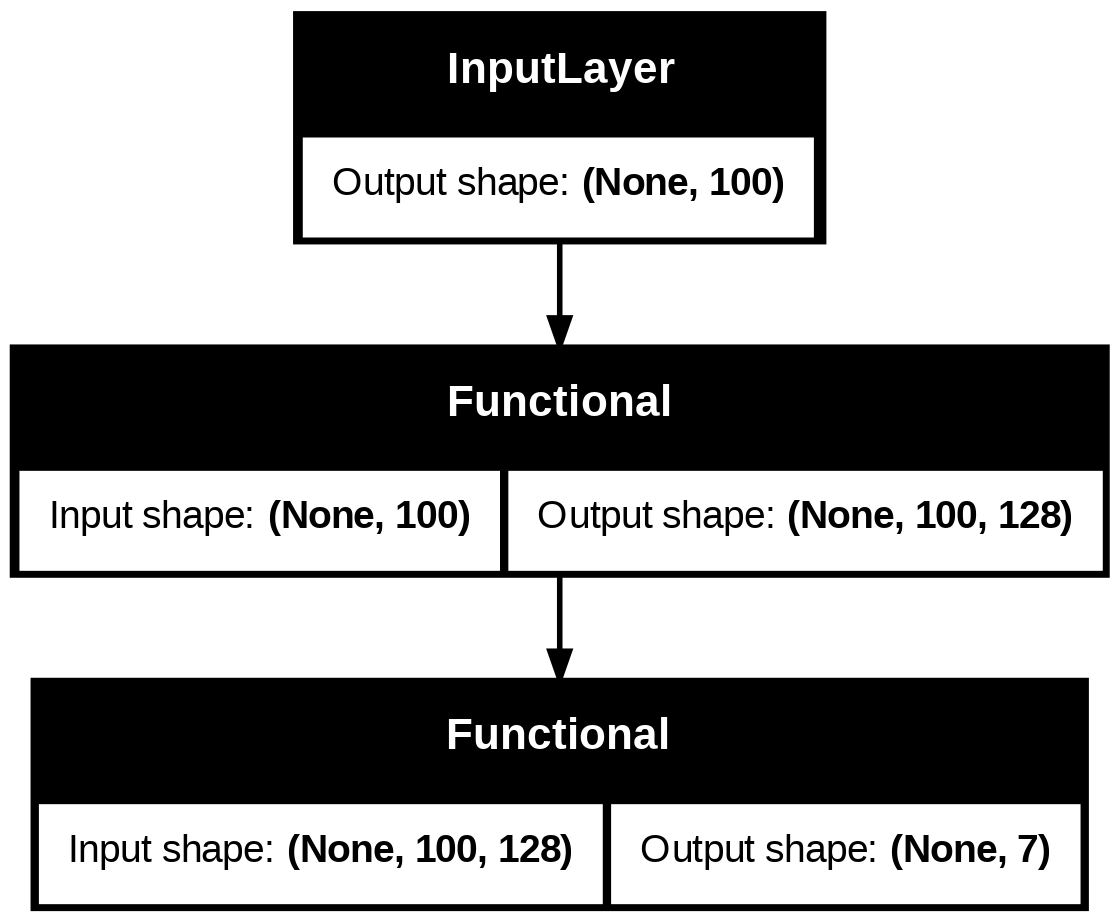

In [38]:
# Visualize the model (and submodel) structure.
plot_model(rnn_model_func_api, to_file='rnn_structure.png', show_shapes=True)

In [39]:
# Prepare to show accuracy and loss data for both the training and validation sets.
rnn_func_history_dict = rnn_func_history.history

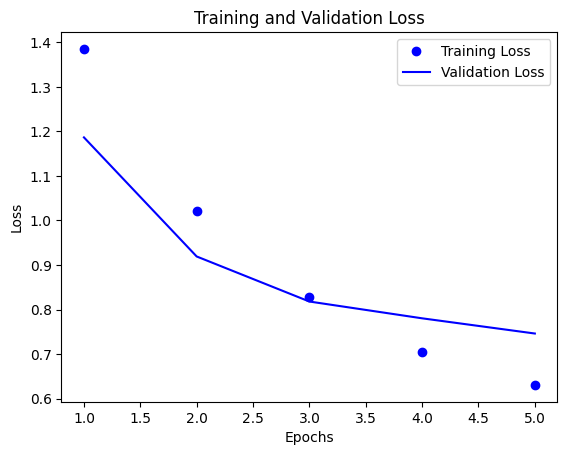

In [40]:
def plot_loss(model_history):
  loss = model_history['loss']
  val_loss = model_history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def plot_accuracy(model_history):
  accuracy = model_history['accuracy']
  val_accuracy = model_history['val_accuracy']

  epochs = range(1, len(accuracy) + 1)

  plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

plot_loss(rnn_func_history_dict)

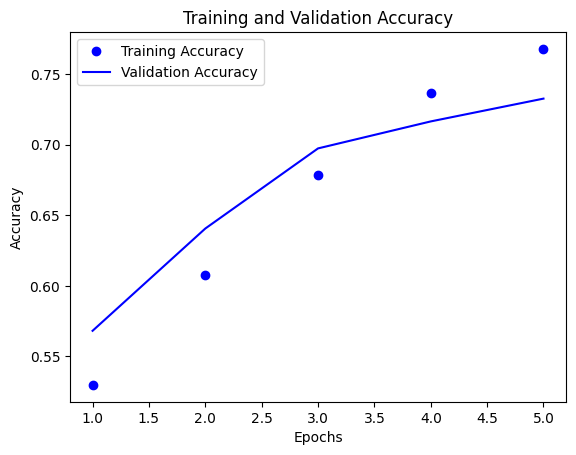

In [41]:
plt.clf() # clear the figure

plot_accuracy(rnn_func_history_dict)

In [42]:
# Define k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# To collect accuracy scores for each fold
all_fold_accuracies = []
all_fold_prec = []
all_fold_recall = []
all_fold_f1 = []

y_train_rnn_classes = np.argmax(y_train_rnn, axis = 1)

for (train_index, val_index) in skf.split(X_train_rnn, y_train_rnn_classes):
  # Get train and validation sets for the current fold
  X_train_fold, X_val_fold = X_train_rnn[train_index], X_train_rnn[val_index]
  y_train_fold, y_val_fold = y_train_rnn[train_index], y_train_rnn[val_index]

  # Rebuild model for each fold
  rnn_fold_model = build_rnn_func_submodels()

  # Train the model
  rnn_fold_model.fit(
      X_train_fold, y_train_fold,
      validation_data=(X_val_fold, y_val_fold),
      # epochs = 4,
      epochs = 5,
      batch_size = 512,
      verbose = 1
  )

  # predict probabilities for the validation set for this fold
  y_pred_fold = rnn_model_func_api.predict(X_val_fold, verbose = 0)
  # predict classes for the validation set for this fold
  y_pred_fold_classes = np.argmax(y_pred_fold, axis = 1)
  # Convert y_test_rnn to a multiclass format like y_pred_rnn_classes
  # to prevent a "multilabel-indicator and multiclass targets" error
  y_test_fold_classes = np.argmax(y_val_fold, axis=1) # Convert to the same format as y_pred_rnn_classes

  # Gather performance metrics for this fold, to be averaged later.
  acc = accuracy_score(y_test_fold_classes, y_pred_fold_classes)
  f1 = f1_score(y_test_fold_classes, y_pred_fold_classes, average = "weighted") # f1 score, using average = 'weighted' because the target is multiclass
  prec = precision_score(y_test_fold_classes, y_pred_fold_classes, average = "weighted", zero_division = np.nan) # precision
  recall = recall_score(y_test_fold_classes, y_pred_fold_classes, average = "weighted")
  all_fold_accuracies.append(acc)
  all_fold_prec.append(prec)
  all_fold_recall.append(recall)
  all_fold_f1.append(f1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 100, 128)            │      15,104,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,369,351 (58.63 MB)

 Trainable params: 15,369,351 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 696ms/step - accuracy: 0.4795 - loss: 1.5809 - val_accuracy: 0.5659 - val_loss: 1.1515
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 709ms/step - accuracy: 0.5939 - loss: 1.0854 - val_accuracy: 0.6486 - val_loss: 0.8987
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 689ms/step - accuracy: 0.6713 - loss: 0.8540 - val_accuracy: 0.7013 - val_loss: 0.7977
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 690ms/step - accuracy: 0.7353 - loss: 0.7165 - val_accuracy: 0.7211 - val_loss: 0.7657
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 690ms/step - accuracy: 0.7724 - loss: 0.6309 - val_accuracy: 0.7353 - val_loss: 0.7301


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 100, 128)            │      15,104,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_7 (Functional)            │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,369,351 (58.63 MB)

 Trainable params: 15,369,351 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 681ms/step - accuracy: 0.4803 - loss: 1.5962 - val_accuracy: 0.5588 - val_loss: 1.1544
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 694ms/step - accuracy: 0.5839 - loss: 1.0800 - val_accuracy: 0.6339 - val_loss: 0.9194
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 671ms/step - accuracy: 0.6512 - loss: 0.8664 - val_accuracy: 0.6920 - val_loss: 0.8145
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 701ms/step - accuracy: 0.7211 - loss: 0.7358 - val_accuracy: 0.7313 - val_loss: 0.7310
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 691ms/step - accuracy: 0.7818 - loss: 0.6088 - val_accuracy: 0.7484 - val_loss: 0.7099


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, 100, 128)            │      15,104,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,369,351 (58.63 MB)

 Trainable params: 15,369,351 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 716ms/step - accuracy: 0.4838 - loss: 1.5828 - val_accuracy: 0.5669 - val_loss: 1.1940
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 685ms/step - accuracy: 0.5888 - loss: 1.1025 - val_accuracy: 0.6487 - val_loss: 0.9283
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 688ms/step - accuracy: 0.6677 - loss: 0.8620 - val_accuracy: 0.6965 - val_loss: 0.8088
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 677ms/step - accuracy: 0.7401 - loss: 0.7083 - val_accuracy: 0.7315 - val_loss: 0.7431
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 693ms/step - accuracy: 0.7800 - loss: 0.6177 - val_accuracy: 0.7380 - val_loss: 0.7375


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_12 (Functional)           │ (None, 100, 128)            │      15,104,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_13 (Functional)           │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,369,351 (58.63 MB)

 Trainable params: 15,369,351 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 715ms/step - accuracy: 0.4772 - loss: 1.5878 - val_accuracy: 0.5763 - val_loss: 1.1446
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 696ms/step - accuracy: 0.5874 - loss: 1.0944 - val_accuracy: 0.6482 - val_loss: 0.9000
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 739ms/step - accuracy: 0.6585 - loss: 0.8648 - val_accuracy: 0.6923 - val_loss: 0.8033
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 680ms/step - accuracy: 0.7180 - loss: 0.7465 - val_accuracy: 0.7242 - val_loss: 0.7621
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 673ms/step - accuracy: 0.7627 - loss: 0.6551 - val_accuracy: 0.7384 - val_loss: 0.7187


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_15 (Functional)           │ (None, 100, 128)            │      15,104,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_16 (Functional)           │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,369,351 (58.63 MB)

 Trainable params: 15,369,351 (58.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 702ms/step - accuracy: 0.4862 - loss: 1.5873 - val_accuracy: 0.5713 - val_loss: 1.1582
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 667ms/step - accuracy: 0.5924 - loss: 1.0668 - val_accuracy: 0.6553 - val_loss: 0.9013
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 683ms/step - accuracy: 0.6716 - loss: 0.8364 - val_accuracy: 0.6932 - val_loss: 0.8161
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 696ms/step - accuracy: 0.7363 - loss: 0.7070 - val_accuracy: 0.7260 - val_loss: 0.7639
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 666ms/step - accuracy: 0.7762 - loss: 0.6159 - val_accuracy: 0.7411 - val_loss: 0.7230


In [43]:
# Compute final average accuracy
final_avg_accuracy = np.mean(all_fold_accuracies)
print("Average Accuracy for Recurrent Neural Network: " + str(final_avg_accuracy))

# Compute final average metrics
final_avg_prec = np.mean(all_fold_prec)
final_avg_recall = np.mean(all_fold_recall)
final_avg_f1 = np.mean(all_fold_f1)
print("Average Precision for Recurrent Neural Network: " + str(final_avg_prec))
print("Average Recall for Recurrent Neural Network: " + str(final_avg_recall))
print("Average F1 Score for Recurrent Neural Network: " + str(final_avg_f1))

Average Accuracy for Recurrent Neural Network: 0.7983817282110156
Average Precision for Recurrent Neural Network: 0.8015381836841963
Average Recall for Recurrent Neural Network: 0.7983817282110156
Average F1 Score for Recurrent Neural Network: 0.7913835992699466


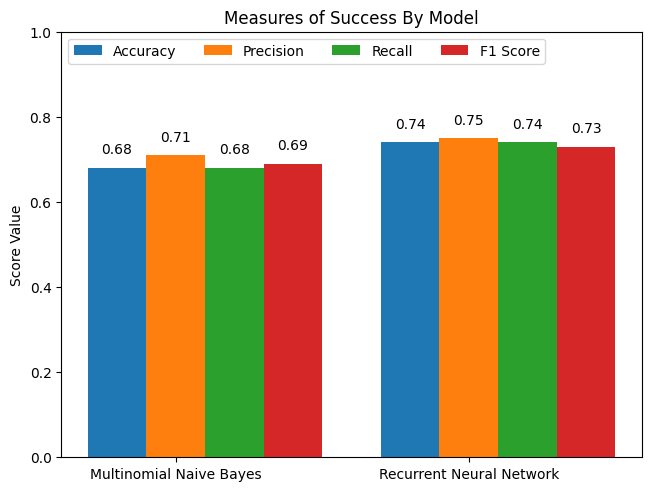

In [44]:
# Data visualisation for the performance of each model.
model_types = ("Multinomial Naive Bayes", "Recurrent Neural Network")

# for the locations of the label on the chart
label_x = np.arange(len(model_types))
bar_width = 0.2
multiplier = 0

measures = {
    "Accuracy": (round(acc_nb, 2), round(acc_rnn, 2)),
    "Precision": (round(prec_nb, 2), round(prec_rnn, 2)),
    "Recall": (round(recall_nb, 2), round(recall_rnn, 2)),
    "F1 Score": (round(f1_nb, 2), round(f1_rnn, 2))
}

fig, ax = plt.subplots(layout = "constrained")

for attribute, measurement in measures.items():
    offset = bar_width * multiplier
    rects = ax.bar(label_x + offset, measurement, bar_width, label = attribute)
    ax.bar_label(rects, padding = 8)
    multiplier += 1

ax.set_ylabel("Score Value")
ax.set_title("Measures of Success By Model")
ax.set_xticks(label_x + bar_width, model_types)
ax.legend(loc = "upper left", ncols = 4)
ax.set_ylim(0, 1)

plt.show()

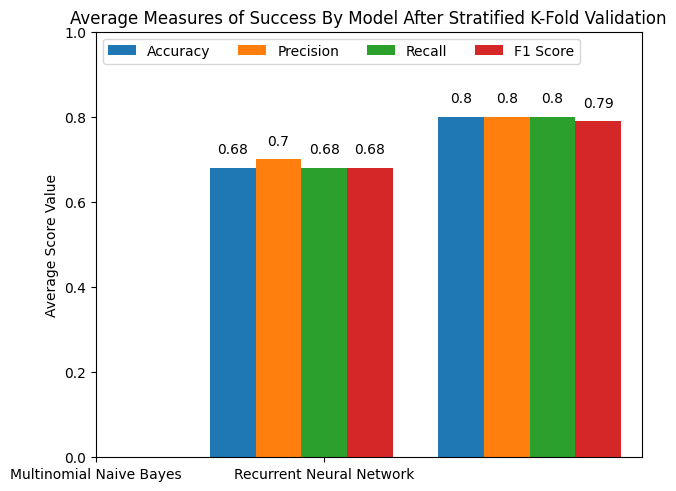

In [45]:
# Data visualisation for the performance of each model after stratified K-fold validation.
avg_measures = {
    "Accuracy": (round(avg_acc_nb, 2), round(final_avg_accuracy, 2)),
    "Precision": (round(avg_prec_nb, 2), round(final_avg_prec, 2)),
    "Recall": (round(avg_recall_nb, 2), round(final_avg_recall, 2)),
    "F1 Score": (round(avg_f1_nb, 2), round(final_avg_f1, 2))
}

fig, ax = plt.subplots(layout = "constrained")

for attribute, measurement in avg_measures.items():
    offset = bar_width * multiplier
    rects = ax.bar(label_x + offset, measurement, bar_width, label = attribute)
    ax.bar_label(rects, padding = 8)
    multiplier += 1

ax.set_ylabel("Average Score Value")
ax.set_title("Average Measures of Success By Model After Stratified K-Fold Validation")
ax.set_xticks(label_x + bar_width, model_types)
ax.legend(loc = "upper left", ncols = 4)
ax.set_ylim(0, 1)

plt.show()